In [ ]:
!pip install torch torchvision scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
# --- CIFAR-10 datasets & loaders ---
import numpy as np
from torch.utils.data import Subset

transform = transforms.ToTensor()  # keep it simple: just [0,1]

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Use only 10k training images instead of 50k
n_small = 50000
all_idx = np.random.permutation(len(train_dataset))[:n_small]
train_dataset_small = Subset(train_dataset, all_idx)

train_loader_small = DataLoader(train_dataset_small, batch_size=batch_size,
                                shuffle=True, num_workers=2)



len(train_dataset_small), len(test_dataset)


(50000, 10000)

In [ ]:
patch_size = 4  # non-overlapping 4x4 patches

def extract_patches_batch(x, patch_size=patch_size):
    """
    x: (B,3,H,W)
    returns: patches_flat (B*P, D), where D = 3*ps*ps, P = num patches per image
    """
    B, C, H, W = x.shape
    ps = patch_size
    assert H % ps == 0 and W % ps == 0
    n_h = H // ps
    n_w = W // ps

    # reshape to (B, C, n_h, ps, n_w, ps) then permute
    x_reshaped = x.view(B, C, n_h, ps, n_w, ps)
    # bring patches together: (B, n_h, n_w, C, ps, ps)
    x_reshaped = x_reshaped.permute(0, 2, 4, 1, 3, 5)
    # flatten patches: (B * n_h * n_w, C*ps*ps)
    patches = x_reshaped.reshape(B * n_h * n_w, C * ps * ps)
    return patches, n_h, n_w

def fold_patches_batch(patches, B, n_h, n_w, patch_size=patch_size):
    """
    patches: (B*P, D)
    returns: x: (B,3,H,W)
    """
    ps = patch_size
    Cpsps = patches.shape[1]
    C = 3
    assert Cpsps == C * ps * ps

    # back to (B, n_h, n_w, C, ps, ps)
    x_reshaped = patches.view(B, n_h, n_w, C, ps, ps)
    # permute back to (B, C, n_h, ps, n_w, ps)
    x_reshaped = x_reshaped.permute(0, 3, 1, 4, 2, 5)
    # final reshape to (B, C, H, W)
    x = x_reshaped.reshape(B, C, n_h * ps, n_w * ps)
    return x


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,   64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 64x16x16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 128x8x8
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 256x4x4
        )

    def forward(self, x):
        return self.conv(x)       # (B,256,4,4)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),  # 128x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),   # 64x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 2, stride=2),     # 3x32x32
            nn.Sigmoid(),  # outputs in [0,1]
        )

    def forward(self, h):
        return self.deconv(h)


class PCA_LDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x_noisy):
        h = self.encoder(x_noisy)
        x_rec = self.decoder(h)
        return x_rec, h


In [ ]:
def pca_encode_patches(x, pca, latent_dim):
    """
    x: (B,3,32,32)
    returns:
      z:   (B, P, latent_dim)
      n_h, n_w
    """
    B = x.size(0)
    patches, n_h, n_w = extract_patches_batch(x)           # (B*P, D)
    patches_np = patches.cpu().numpy()
    z_np = pca.transform(patches_np)                       # (B*P, latent_dim)
    z = torch.from_numpy(z_np).float().to(device)
    P = n_h * n_w
    z = z.view(B, P, latent_dim)
    return z, n_h, n_w

def pca_decode_patches(z, n_h, n_w, pca, latent_dim):
    """
    z: (B, P, latent_dim)
    returns: x_recon: (B,3,32,32)
    """
    B, P, d = z.shape
    assert d == latent_dim
    z_flat = z.view(B * P, d)
    z_np = z_flat.cpu().numpy()
    patches_np = pca.inverse_transform(z_np)               # (B*P, D)
    patches = torch.from_numpy(patches_np).float().to(device)
    x = fold_patches_batch(patches, B, n_h, n_w, patch_size=patch_size)
    x = torch.clamp(x, 0.0, 1.0)
    return x


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,   64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 64x16x16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 128x8x8
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),      # 256x4x4
        )

    def forward(self, x):
        return self.conv(x)       # (B,256,4,4)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),  # 128x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),   # 64x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 2, stride=2),     # 3x32x32
            nn.Sigmoid(),  # outputs in [0,1]
        )

    def forward(self, h):
        return self.deconv(h)


class PCA_LDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x_noisy):
        h = self.encoder(x_noisy)
        x_rec = self.decoder(h)
        return x_rec, h


In [ ]:
from sklearn.decomposition import PCA

latent_dim = 16
n_pca_samples = 5000  # small, fast

all_idx = np.random.permutation(len(train_dataset_small))[:n_pca_samples]
subset = Subset(train_dataset_small, all_idx)
subset_loader = DataLoader(subset, batch_size=256, shuffle=False)

patches_list = []
for x, _ in subset_loader:
    p_flat, _, _ = extract_patches_batch(x)  # (B*P, 48)
    patches_list.append(p_flat.numpy())

X_patches = np.concatenate(patches_list, axis=0)
print("PCA training patches shape:", X_patches.shape)

pca_16 = PCA(n_components=latent_dim, svd_solver="randomized")
pca_16.fit(X_patches)

print("Patch-wise PCA fitted. Latent dim =", latent_dim)


PCA training patches shape: (320000, 48)
Patch-wise PCA fitted. Latent dim = 16


In [ ]:
model_16 = PCA_LDAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_16.parameters(), lr=1e-3)

T         = 10
sigma_min = 0.0
sigma_max = np.sqrt(2.0)

num_epochs_ae = 20

model_16.train()
for epoch in range(num_epochs_ae):
    running_loss = 0.0
    for x, _ in train_loader_small:
        x = x.to(device)

        # patch-wise PCA latent + multi-level noise
        z, n_h, n_w = pca_encode_patches(x, pca_16, latent_dim)  # (B,P,16)
        B, P, d = z.shape

        t = torch.randint(low=0, high=T, size=(B,), device=device).float()
        sigmas = sigma_min + (sigma_max - sigma_min) * (t / (T - 1))  # (B,)
        sigmas = sigmas.view(B, 1, 1)

        eps = torch.randn_like(z)
        z_noisy = z + eps * sigmas

        x_noisy = pca_decode_patches(z_noisy, n_h, n_w, pca_16, latent_dim)

        optimizer.zero_grad()
        x_rec, _ = model_16(x_noisy)
        loss = criterion(x_rec, x)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

    epoch_loss = running_loss / len(train_dataset_small)
    print(f"[AE Epoch {epoch+1}/{num_epochs_ae}] MSE: {epoch_loss:.6f}")

print("AE training done (d=16).")


[AE Epoch 1/20] MSE: 0.023853
[AE Epoch 2/20] MSE: 0.017072
[AE Epoch 3/20] MSE: 0.016082
[AE Epoch 4/20] MSE: 0.015421
[AE Epoch 5/20] MSE: 0.015058
[AE Epoch 6/20] MSE: 0.014812
[AE Epoch 7/20] MSE: 0.014648
[AE Epoch 8/20] MSE: 0.014465
[AE Epoch 9/20] MSE: 0.014348
[AE Epoch 10/20] MSE: 0.014327
[AE Epoch 11/20] MSE: 0.014219
[AE Epoch 12/20] MSE: 0.014166
[AE Epoch 13/20] MSE: 0.014069
[AE Epoch 14/20] MSE: 0.013986
[AE Epoch 15/20] MSE: 0.013992
[AE Epoch 16/20] MSE: 0.013929
[AE Epoch 17/20] MSE: 0.013862
[AE Epoch 18/20] MSE: 0.013827
[AE Epoch 19/20] MSE: 0.013742
[AE Epoch 20/20] MSE: 0.013740
AE training done (d=16).


In [ ]:
# freeze encoder
for p in model_16.encoder.parameters():
    p.requires_grad = False
model_16.eval()

def extract_features(dataloader):
    feats = []
    labels = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            _, h = model_16(x)         # (B,256,4,4)
            h_pool = h.mean(dim=(2, 3))  # (B,256)
            feats.append(h_pool.cpu())
            labels.append(y)
    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    return feats, labels

train_feats, train_labels = extract_features(train_loader_small)
test_feats,  test_labels  = extract_features(test_loader)

train_feats.shape, test_feats.shape


(torch.Size([50000, 256]), torch.Size([10000, 256]))

In [ ]:
from torch.utils.data import TensorDataset

class LinearClassifier(nn.Module):
    def __init__(self, in_dim=256, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

clf_16 = LinearClassifier(in_dim=train_feats.size(1), num_classes=10).to(device)
optimizer_clf = optim.Adam(clf_16.parameters(), lr=1e-3)
criterion_ce  = nn.CrossEntropyLoss()

batch_size_lp = 256

def make_lp_loader(features, labels, shuffle):
    ds = TensorDataset(features, labels)
    return DataLoader(ds, batch_size=batch_size_lp, shuffle=shuffle)

train_lp_loader = make_lp_loader(train_feats, train_labels, shuffle=True)
test_lp_loader  = make_lp_loader(test_feats,  test_labels,  shuffle=False)


In [ ]:
num_epochs_lp = 15

for epoch in range(num_epochs_lp):
    clf_16.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for f, y in train_lp_loader:
        f = f.to(device)
        y = y.to(device)

        optimizer_clf.zero_grad()
        logits = clf_16(f)
        loss = criterion_ce(logits, y)
        loss.backward()
        optimizer_clf.step()

        running_loss += loss.item() * f.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total * 100.0
    print(f"[LP Epoch {epoch+1}/{num_epochs_lp}] Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")

# test
clf_16.eval()
correct = 0
total   = 0
with torch.no_grad():
    for f, y in test_lp_loader:
        f = f.to(device)
        y = y.to(device)
        logits = clf_16(f)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

test_acc_16 = correct / total * 100.0
print(f"l-DAE (patch PCA, d=16) CIFAR-10 Test Acc: {test_acc_16:.2f}%")


[LP Epoch 1/15] Loss: 2.0805, Acc: 26.41%
[LP Epoch 2/15] Loss: 1.9055, Acc: 33.59%
[LP Epoch 3/15] Loss: 1.8322, Acc: 35.71%
[LP Epoch 4/15] Loss: 1.7866, Acc: 37.08%
[LP Epoch 5/15] Loss: 1.7537, Acc: 38.13%
[LP Epoch 6/15] Loss: 1.7280, Acc: 38.88%
[LP Epoch 7/15] Loss: 1.7090, Acc: 39.31%
[LP Epoch 8/15] Loss: 1.6945, Acc: 39.73%
[LP Epoch 9/15] Loss: 1.6800, Acc: 40.11%
[LP Epoch 10/15] Loss: 1.6672, Acc: 40.69%
[LP Epoch 11/15] Loss: 1.6567, Acc: 41.04%
[LP Epoch 12/15] Loss: 1.6489, Acc: 41.30%
[LP Epoch 13/15] Loss: 1.6389, Acc: 41.69%
[LP Epoch 14/15] Loss: 1.6309, Acc: 42.01%
[LP Epoch 15/15] Loss: 1.6253, Acc: 42.11%
l-DAE (patch PCA, d=16) CIFAR-10 Test Acc: 42.34%


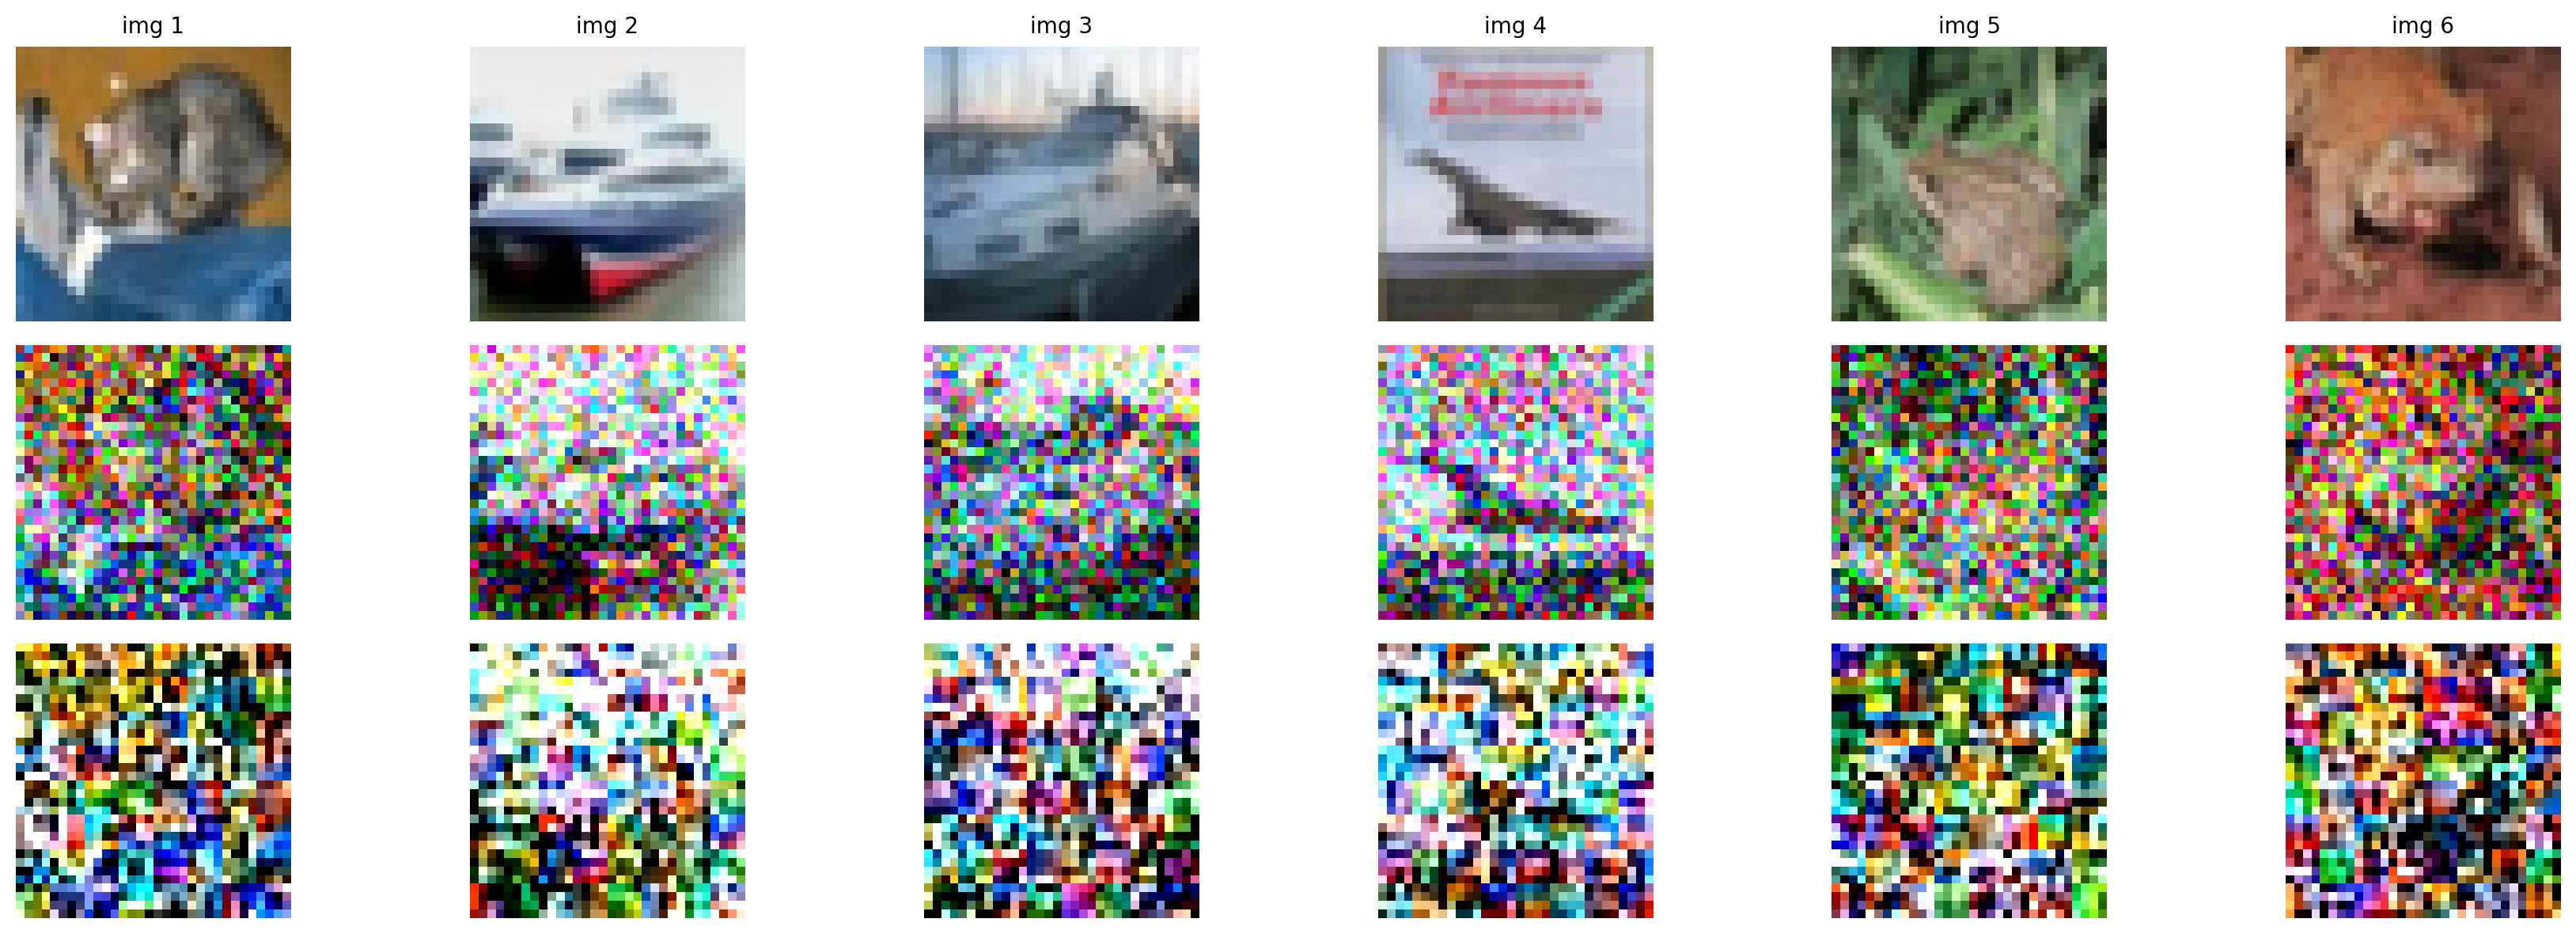

In [ ]:
import matplotlib.pyplot as plt

model_16.eval()

# --- pick N images ---
x_batch, _ = next(iter(test_loader))
x_batch = x_batch.to(device)
n_imgs = 6   # number of columns
x = x_batch[:n_imgs]

# 1) pixel noise
sigma_pixel = 0.3
x_noisy_pixel = x + sigma_pixel * torch.randn_like(x)
x_noisy_pixel = torch.clamp(x_noisy_pixel, 0.0, 1.0)

# 2) latent noise
z, n_h, n_w = pca_encode_patches(x, pca_16, latent_dim)
sigma_latent = 0.8
eps = torch.randn_like(z)
z_noisy = z + sigma_latent * eps
x_noisy_latent = pca_decode_patches(z_noisy, n_h, n_w, pca_16, latent_dim)

x_clean        = x.cpu()
x_noisy_pixel  = x_noisy_pixel.cpu()
x_noisy_latent = x_noisy_latent.cpu()

rows = 3
cols = n_imgs

row_titles = ["Clean", "Pixel noise", "Latent noise"]
row_imgs   = [x_clean, x_noisy_pixel, x_noisy_latent]

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 6), dpi=200)

for r in range(rows):
    for c in range(cols):
        axes[r, c].imshow(row_imgs[r][c].permute(1, 2, 0).numpy())
        axes[r, c].axis("off")
    # put big label on the left of each row
    axes[r, 0].set_ylabel(row_titles[r], fontsize=16, rotation=90, labelpad=20)

# optional: label columns with numbers
for c in range(cols):
    axes[0, c].set_title(f"img {c+1}", fontsize=10)

plt.tight_layout()
plt.show()


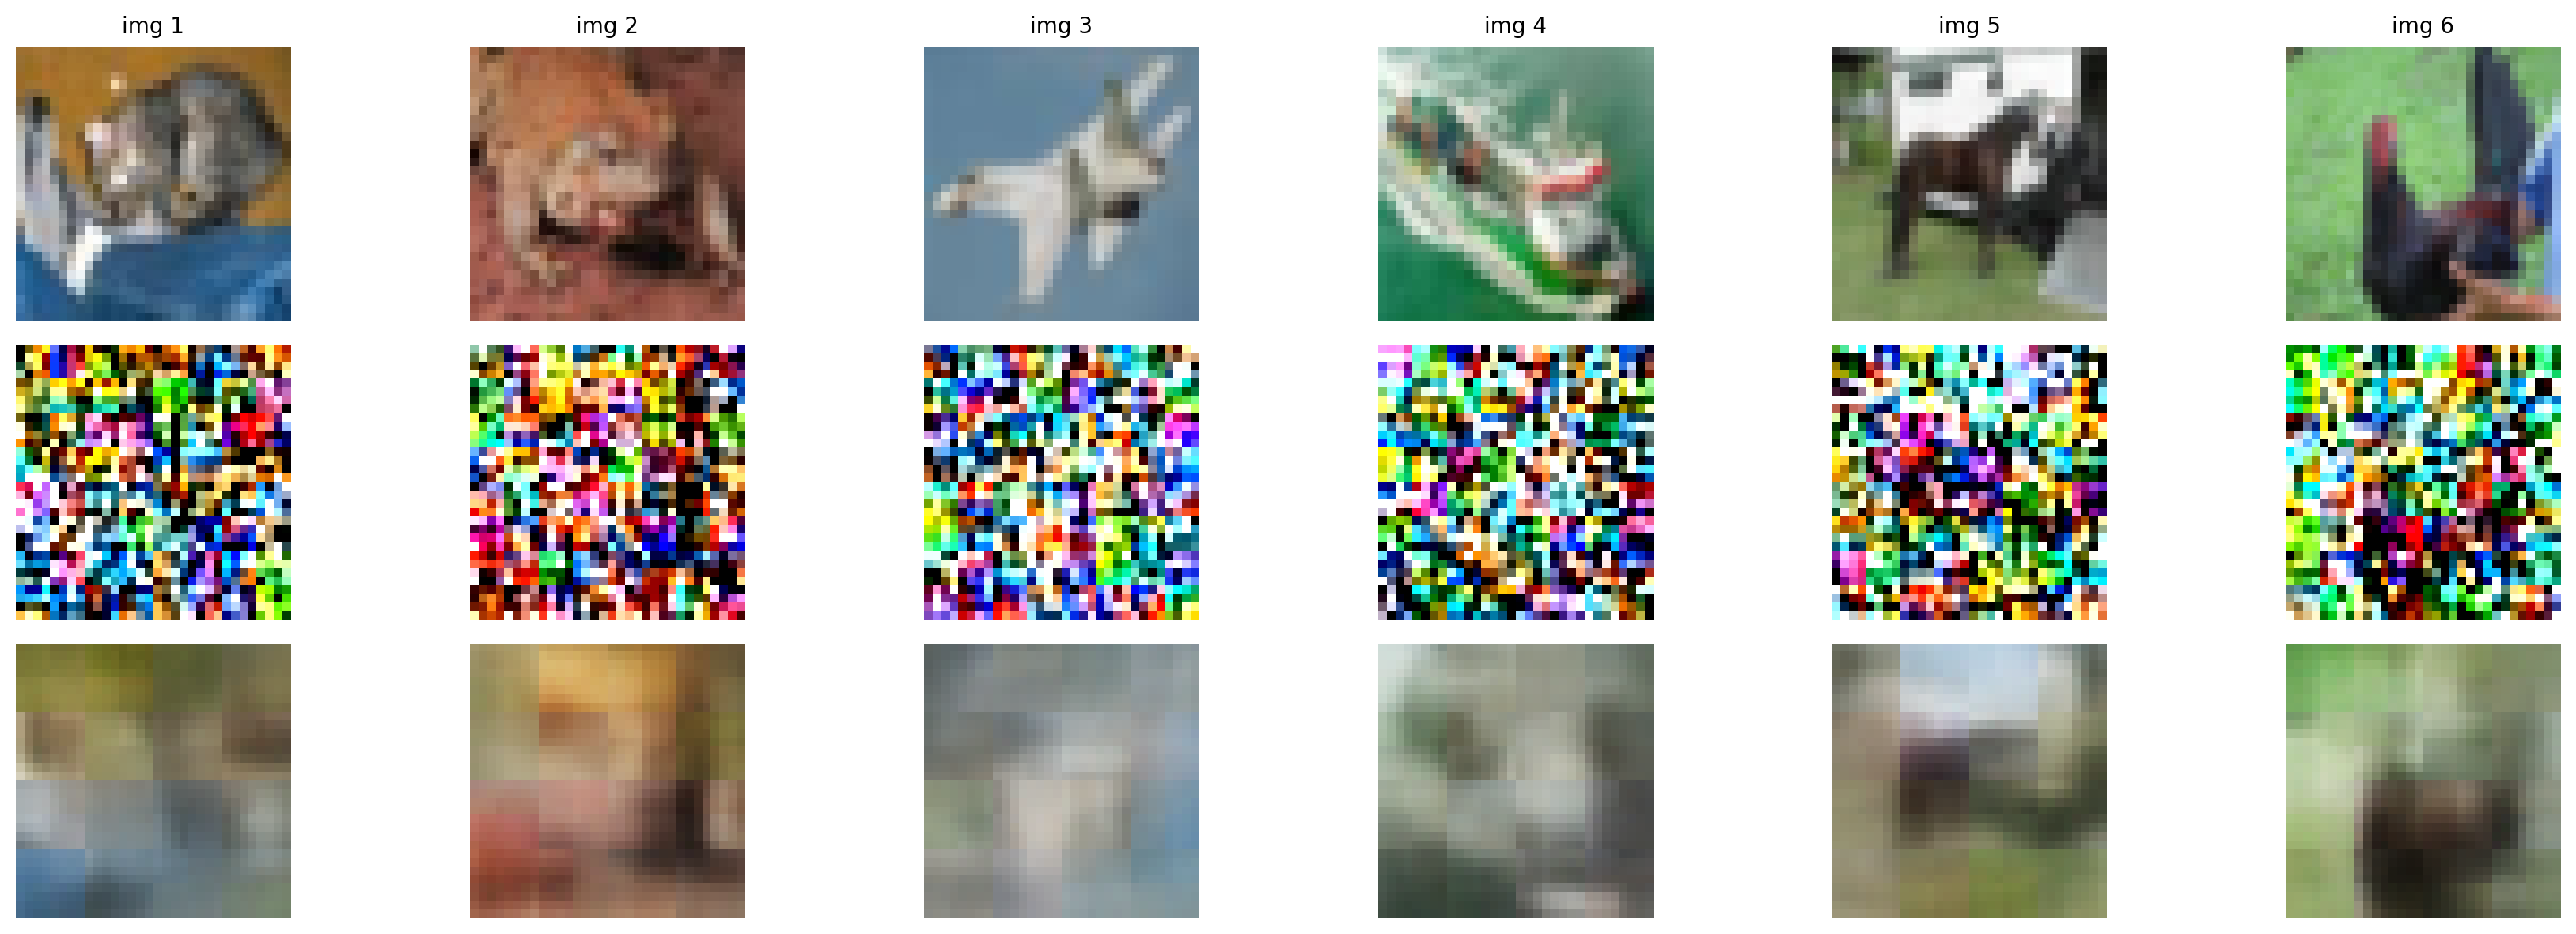

In [ ]:
model_16.eval()

# x_batch, _ = next(iter(test_loader))
# x_batch = x_batch.to(device)
# n_imgs = 6
indices = [0, 5, 10, 15, 20, 25]
x_list = [test_dataset[i][0] for i in indices]
x = torch.stack(x_list).to(device)
# x = x_batch[:n_imgs]

# latent noise
z, n_h, n_w = pca_encode_patches(x, pca_16, latent_dim)
sigma_latent_strong = 1.0
eps = torch.randn_like(z)
z_noisy = z + sigma_latent_strong * eps
x_noisy_latent = pca_decode_patches(z_noisy, n_h, n_w, pca_16, latent_dim)

with torch.no_grad():
    x_denoised, _ = model_16(x_noisy_latent)

x_clean        = x.cpu()
x_noisy_latent = x_noisy_latent.cpu()
x_denoised     = x_denoised.cpu()

rows = 3
cols = n_imgs

row_titles = ["Clean", "Latent-noise input", "Denoised output"]
row_imgs   = [x_clean, x_noisy_latent, x_denoised]

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 6), dpi=200)

for r in range(rows):
    for c in range(cols):
        axes[r, c].imshow(row_imgs[r][c].permute(1, 2, 0).numpy())
        axes[r, c].axis("off")
    axes[r, 0].set_ylabel(row_titles[r], fontsize=16, rotation=90, labelpad=20)

for c in range(cols):
    axes[0, c].set_title(f"img {c+1}", fontsize=10)

plt.tight_layout()
plt.show()
